# Análisis de Breast Cancer Wisconsin (Diagnostic)
*Rubén Valverde Romero*

## Introducción

Este dataset contiene datos sobre las dimensiones de tumores en el pecho, el objetivo final de este dataset es predecir si se trata de un tumor benigno o maligno.

**Contenido** 
   
- *Diagnosis* (M = Maligno, B = Benigno)

Se han calculado diez características con valores reales para cada núcleo celular:

- *radius* (media de distancias desde el centro hasta los puntos en el perímetro)  
- *texture* (desviación estándar de los valores de escala de grises)  
- *perimeter* (perímetro) 
- *area*  
- *smoothness* (variación local en las longitudes del radio)  
- *compactness* (perimeter^2 / area - 1.0)  
- *concavity* (severidad de las porciones cóncavas del contorno)  
- *concave points* (número de porciones cóncavas del contorno)  
- *symmetry*(simetría)  
- *fractal dimension* ("aproximación de la línea de costa" - 1)

**Origen del dataset**  
Wolberg, W., Mangasarian, O., Street, N., & Street, W. (1993). Breast Cancer Wisconsin (Diagnostic) [Dataset]. UCI Machine Learning Repository. https://doi.org/10.24432/C5DW2B.  


## Importación y Limpieza de Datos

In [53]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from skopt import BayesSearchCV
from skopt.space import Integer, Real
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier, NearestCentroid
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler, QuantileTransformer
from statsmodels.api import qqplot
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from imblearn.over_sampling import SMOTE
from feature_engine.selection import SmartCorrelatedSelection
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import PowerTransformer
import warnings
from plotly import express as px
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import StackingClassifier
from sklearn.tree import DecisionTreeClassifier

In [54]:
sns.set(style="darkgrid")
sns.set_palette("tab10")

In [55]:
df = pd.read_csv("dataset/Breast Cancer Wisconsin.csv")
df.head()

,radius1,texture1,perimeter1,area1,smoothness1,compactness1,concavity1,concave_points1,symmetry1,fractal_dimension1,...,texture3,perimeter3,area3,smoothness3,compactness3,concavity3,concave_points3,symmetry3,fractal_dimension3,Diagnosis
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,M
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,M
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,M
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,M
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,M


In [56]:
# todos los nombres de las columnas estan enen minúsculas salvo la columna Diagnosis
df['diagnosis'] = df['Diagnosis']
df.drop(['Diagnosis'], axis=1, inplace=True)

In [57]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 31 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   radius1             569 non-null    float64
 1   texture1            569 non-null    float64
 2   perimeter1          569 non-null    float64
 3   area1               569 non-null    float64
 4   smoothness1         569 non-null    float64
 5   compactness1        569 non-null    float64
 6   concavity1          569 non-null    float64
 7   concave_points1     569 non-null    float64
 8   symmetry1           569 non-null    float64
 9   fractal_dimension1  569 non-null    float64
 10  radius2             569 non-null    float64
 11  texture2            569 non-null    float64
 12  perimeter2          569 non-null    float64
 13  area2               569 non-null    float64
 14  smoothness2         569 non-null    float64
 15  compactness2        569 non-null    float64
 16  concavit

In [58]:
df.describe()

,radius1,texture1,perimeter1,area1,smoothness1,compactness1,concavity1,concave_points1,symmetry1,fractal_dimension1,...,radius3,texture3,perimeter3,area3,smoothness3,compactness3,concavity3,concave_points3,symmetry3,fractal_dimension3
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,0.062798,...,16.269190,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946
std,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,0.007060,...,4.833242,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061
min,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,0.049960,...,7.930000,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040
25%,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,0.057700,...,13.010000,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460
50%,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,0.061540,...,14.970000,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040
75%,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,0.066120,...,18.790000,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080
max,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,0.097440,...,36.040000,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500


In [59]:
df.shape

(569, 31)

**Observaciones**  
+   Todas las columnas son tipo float64 salvo la variable objetivo `diagnosis` 
+   El dataset cuenta con 569 filas y 31 columnas
+   No contiene datos nulos

In [60]:
df.isnull().sum()

radius1               0
texture1              0
perimeter1            0
area1                 0
smoothness1           0
compactness1          0
concavity1            0
concave_points1       0
symmetry1             0
fractal_dimension1    0
radius2               0
texture2              0
perimeter2            0
area2                 0
smoothness2           0
compactness2          0
concavity2            0
concave_points2       0
symmetry2             0
fractal_dimension2    0
radius3               0
texture3              0
perimeter3            0
area3                 0
smoothness3           0
compactness3          0
concavity3            0
concave_points3       0
symmetry3             0
fractal_dimension3    0
diagnosis             0
dtype: int64

In [61]:
variables_continuas = df.select_dtypes(include='float64').columns
df_float16 = df[variables_continuas].astype('float16')

# Comprobar si se ha perdido información
for col in df.select_dtypes(include='float64').columns:
    if np.allclose(df[col], df_float16[col], rtol=1e-03, atol=1e-07):
        print(f'No se ha perdido información en la columna: {col}')
    else:
        print(f'Información perdida en la columna: {col}')

No se ha perdido información en la columna: radius1
No se ha perdido información en la columna: texture1
No se ha perdido información en la columna: perimeter1
No se ha perdido información en la columna: area1
No se ha perdido información en la columna: smoothness1
No se ha perdido información en la columna: compactness1
No se ha perdido información en la columna: concavity1
No se ha perdido información en la columna: concave_points1
No se ha perdido información en la columna: symmetry1
No se ha perdido información en la columna: fractal_dimension1
No se ha perdido información en la columna: radius2
No se ha perdido información en la columna: texture2
No se ha perdido información en la columna: perimeter2
No se ha perdido información en la columna: area2
No se ha perdido información en la columna: smoothness2
No se ha perdido información en la columna: compactness2
No se ha perdido información en la columna: concavity2
No se ha perdido información en la columna: concave_points2
No se h

**Observaciones**  
Dado que no se ha perdido información se efectuará el cambio de tipo

In [62]:
print(f'Memoria antes: {df.memory_usage().sum()}')
df[variables_continuas] = df_float16
print(f'Memoria después: {df.memory_usage().sum()}')

Memoria antes: 141244
Memoria después: 38824


**Observaciones**  
Se ha conseguido reducir el peso del dataframe un 72,5% sin perder información

## Exploración de datos

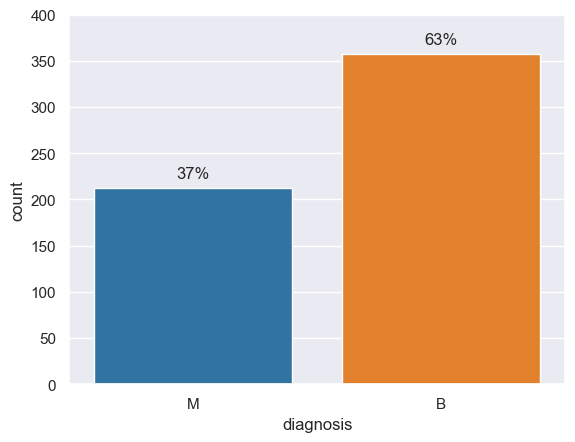

In [63]:
sns.countplot(data=df, x='diagnosis', hue='diagnosis', legend=False)
plt.text('M', 220, '37%', ha='center', va='bottom', fontsize=12)
plt.text('B', 365, '63%', ha='center', va='bottom', fontsize=12)
plt.ylim(0, 400)
plt.show()

**Observaciones**  
+   El número de tumores beningos es casi un 50% superior que el de malignos

In [64]:
df['diagnosis'] = np.where(df['diagnosis'] == 'M', 1, 0)
df['diagnosis'] = df['diagnosis'].astype('category')

### Correlaciones

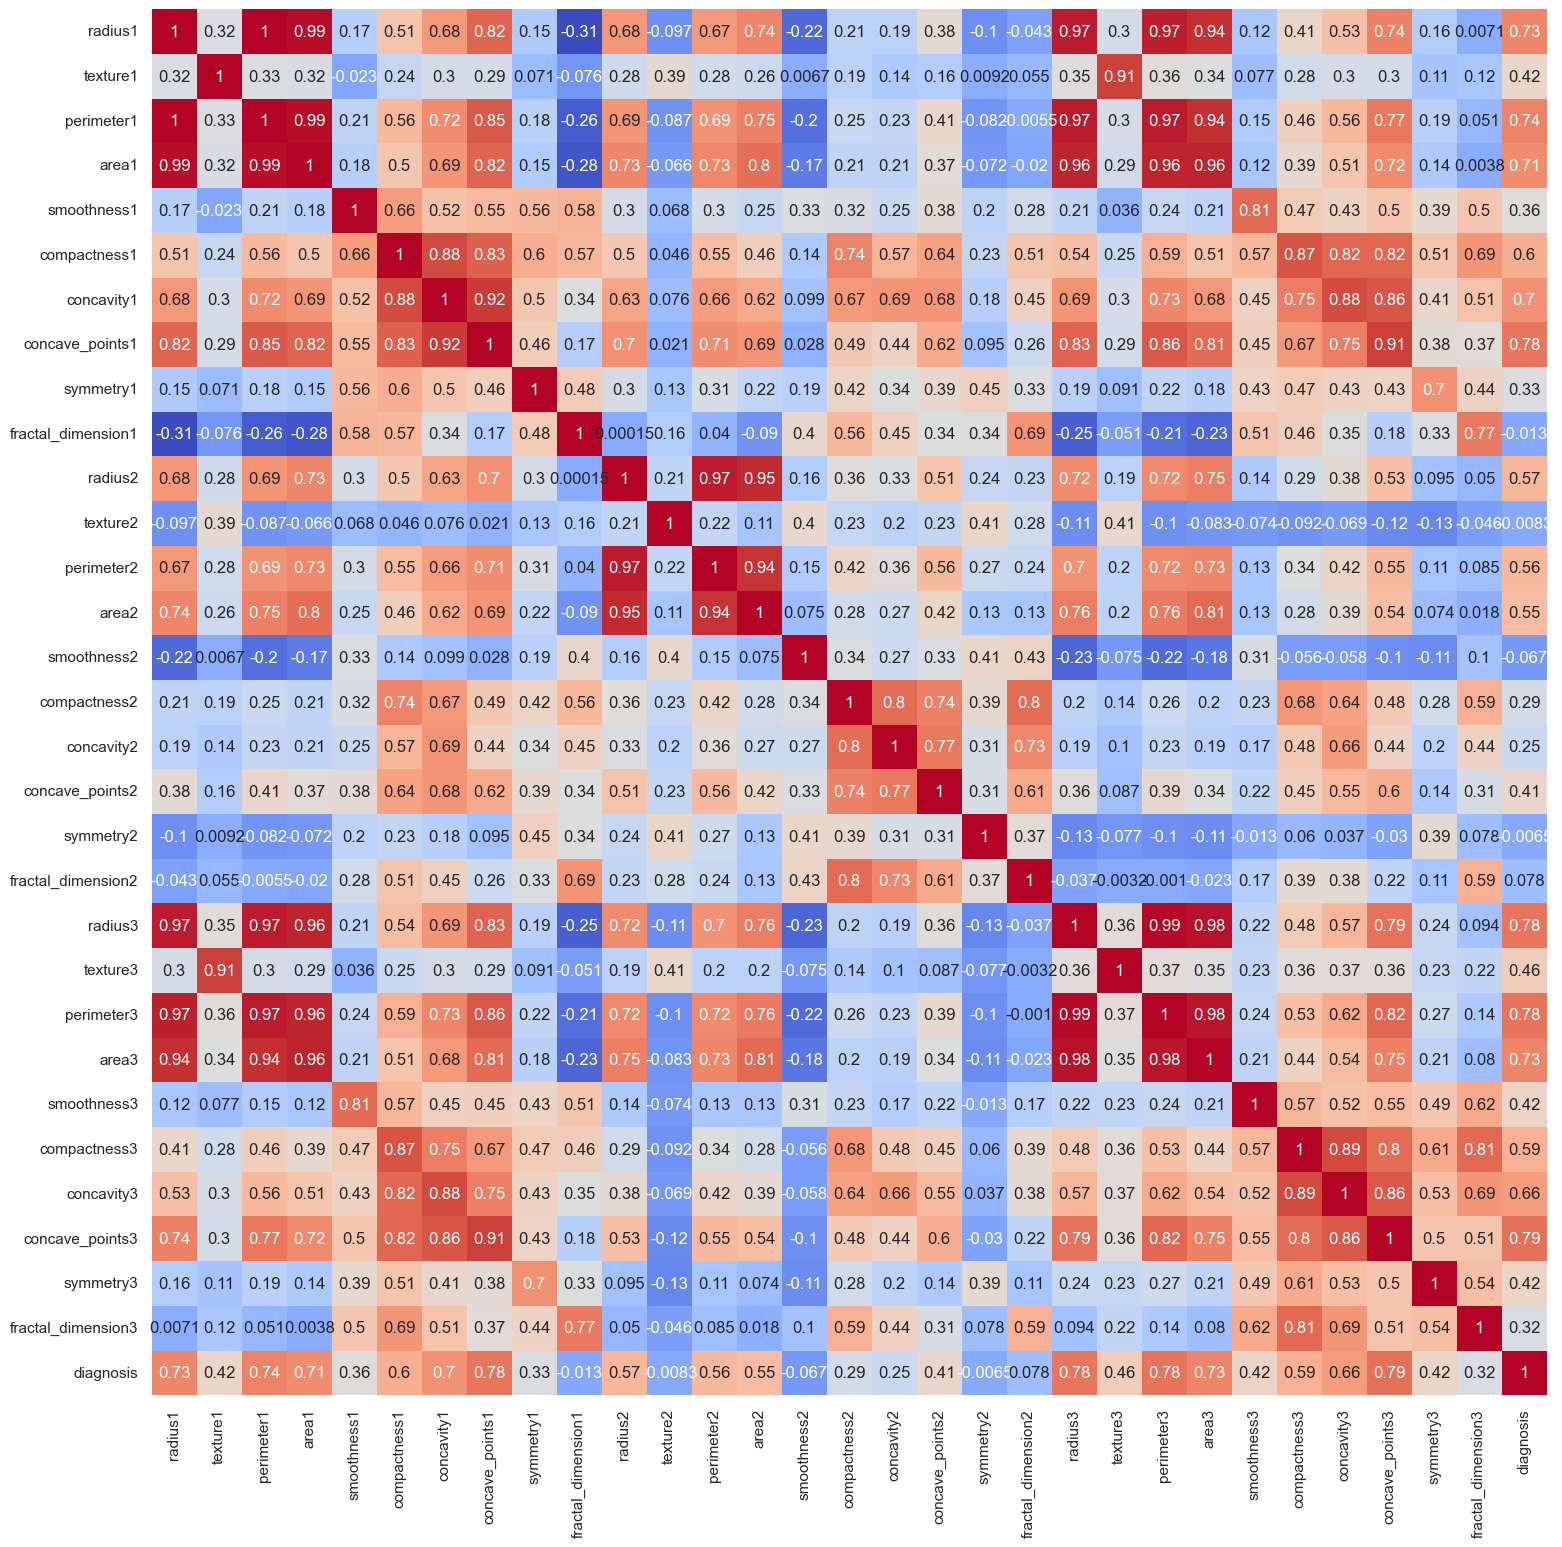

In [65]:
df_correlacion = df.corr()
plt.figure(figsize=(18, 18))
sns.heatmap(df_correlacion, annot=True, cmap='coolwarm', cbar=False)
plt.show()

**Observaciones**  
+   Hay evidencia de multicolinealidad entre varios pares  
+   La variable objetivo tiene desde correlaciones positivas moderadas (0.79) hasta nulas (-0,006)

Se eliminaran las variables con colinealidad o que tengan una correlación debil respecto a `diagnosis`

In [66]:
baja_correlacion = df_correlacion['diagnosis'][np.abs(df_correlacion['diagnosis']) < 0.3].index
baja_correlacion

Index(['fractal_dimension1', 'texture2', 'smoothness2', 'compactness2',
       'concavity2', 'symmetry2', 'fractal_dimension2'],
      dtype='object')

In [67]:
df_filtrado = df.drop(baja_correlacion, axis=1)
df_filtrado.shape

(569, 24)

In [68]:
smart_corr = SmartCorrelatedSelection(
    variables=None,
    method="pearson",
    threshold=0.9
)
df_filtrado = smart_corr.fit_transform(df_filtrado)
df_filtrado.shape

(569, 15)

**Observaciones**  
+   Se ha reducido el nº de dimensiones de 31 a 15

### Distribución respecto al Diagnostico

#### Scatterplots

In [69]:
variables = df_filtrado.columns.drop('diagnosis')
fig = px.scatter_matrix(df_filtrado, 
                        dimensions=variables, 
                        title='Correlación entre todas las variables divididas por diagnóstico',
                        width=1700, 
                        height=1500,
                        opacity=0.25,
                        color_continuous_scale=['orange', 'blue', 'white'],
                        symbol='diagnosis',
                        color='diagnosis')
fig.update_traces(diagonal_visible=True)
fig.update_layout(showlegend=False, coloraxis_showscale=False, font=dict(size=8))
fig.update_xaxes(title_font=dict(size=7), tickfont=dict(size=7))
fig.update_yaxes(title_font=dict(size=7), tickfont=dict(size=7))
fig.show()

**Observaciones**  
+   En todos los pares se observa diferencia entre ambos diagnosticos, teniendo los tumores malignos tendencia a valores más elevados
+   Se confirma que la mayoría de pares posees una correlación positiva de debil a moderada

#### T-SNE

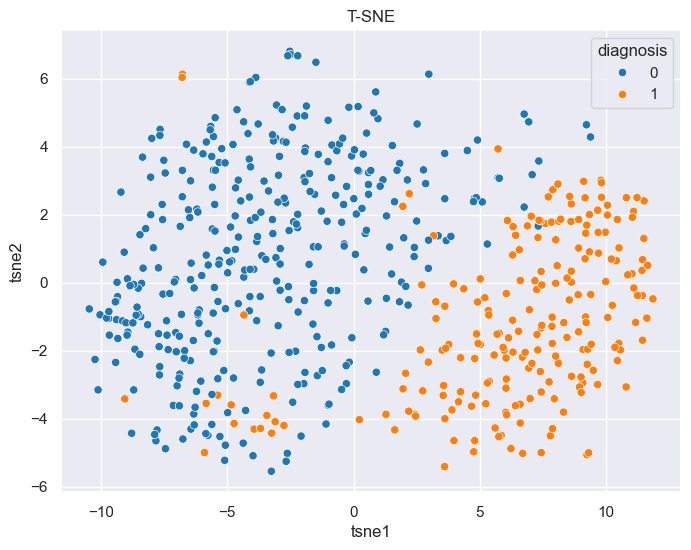

In [70]:
std_scaler = StandardScaler()
X = df_filtrado.drop('diagnosis', axis=1)
X_scale = std_scaler.fit_transform(X)

tsne = TSNE(n_components=2, random_state=27, perplexity=90)
X_tsne = tsne.fit_transform(X_scale)

df_tsne = pd.DataFrame(X_tsne, columns=['tsne1', 'tsne2'])
df_tsne['diagnosis'] = df_filtrado['diagnosis']

fig = plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_tsne, x='tsne1', y='tsne2', hue='diagnosis')
plt.title('T-SNE')
plt.show()

**Observaciones**  
+   Hay una clara distinción entre ambos grupos, sin embargo hay "intrusos" en ambos lados
  
Se realizará la proyección en 3D para ver si existe otro limite entre ambos grupos que los distinga

In [71]:
tsne = TSNE(n_components=3, random_state=27, perplexity=90)
X_tsne = tsne.fit_transform(X_scale)

df_tsne = pd.DataFrame(X_tsne, columns=['tsne1', 'tsne2', 'tsne3'])
df_tsne['diagnosis'] = df_filtrado['diagnosis']

fig = px.scatter_3d(df_tsne, 
                    x='tsne1', 
                    y='tsne2', 
                    z='tsne3', 
                    color='diagnosis', 
                    opacity=0.75, 
                    title='T-SNE',
                    color_continuous_scale=['orange', 'blue'],
                    symbol='diagnosis',
                    width=1000,
                    height=800)
fig.show()

**Observaciones**
+   El objetivo de esta proyección ha sido cumplido con exito, en el eje z se distingue una pendiente que separa ambos grupos
+   Aunque la división ha mejorado todavía persisten tumores malignos cercanos a la concentración de benignos, especialmente 2 que se encuentran colindando con 2 de diagnositco opuesto.

### Distribuciones respecto al diagnostico

#### Violinplots

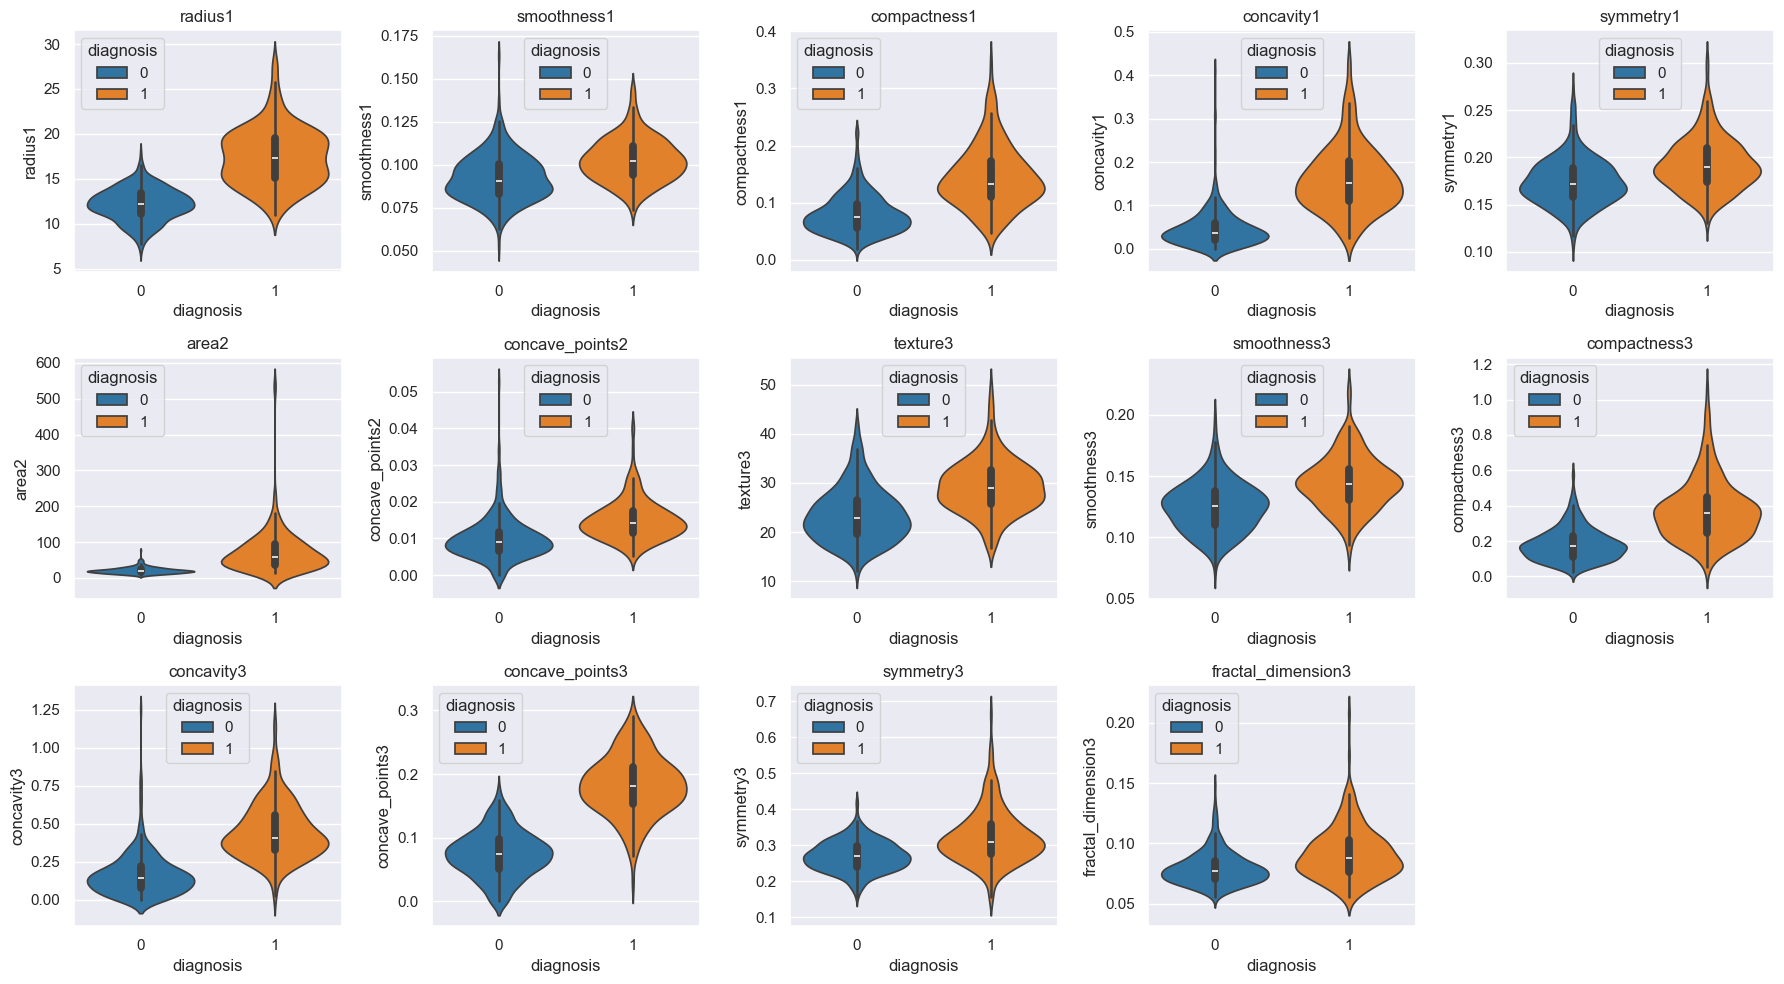

In [72]:
# Crear una lista de variables a graficar
variables = df_filtrado.columns.drop('diagnosis')

# Crear la figura y los ejes
fig, axes = plt.subplots(3, 5, figsize=(18, 10))

# Aplanar los ejes para iterar fácilmente
axes = axes.flatten()

# Iterar sobre las variables y crear los violinplots
for i, var in enumerate(variables):
    sns.violinplot(data=df_filtrado, x='diagnosis', y=var, hue='diagnosis' ,ax=axes[i])
    axes[i].set_title(f'{var}')

# Eliminar los ejes vacíos
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

**Observaciones**  
+   Como se mostraba en la matriz de scatterplots, los valores de las características de los tumores malignos pueden alcanzar valores más elevados que los benignos
+   Los violinplot indican con mayor claridad que ambos tipos de tumor comparten la mayor parte de sus valores en el mismo rango

In [73]:
X = df_filtrado.drop('diagnosis', axis=1)
y = df_filtrado['diagnosis']

## Preparación de los datos

### Normalización

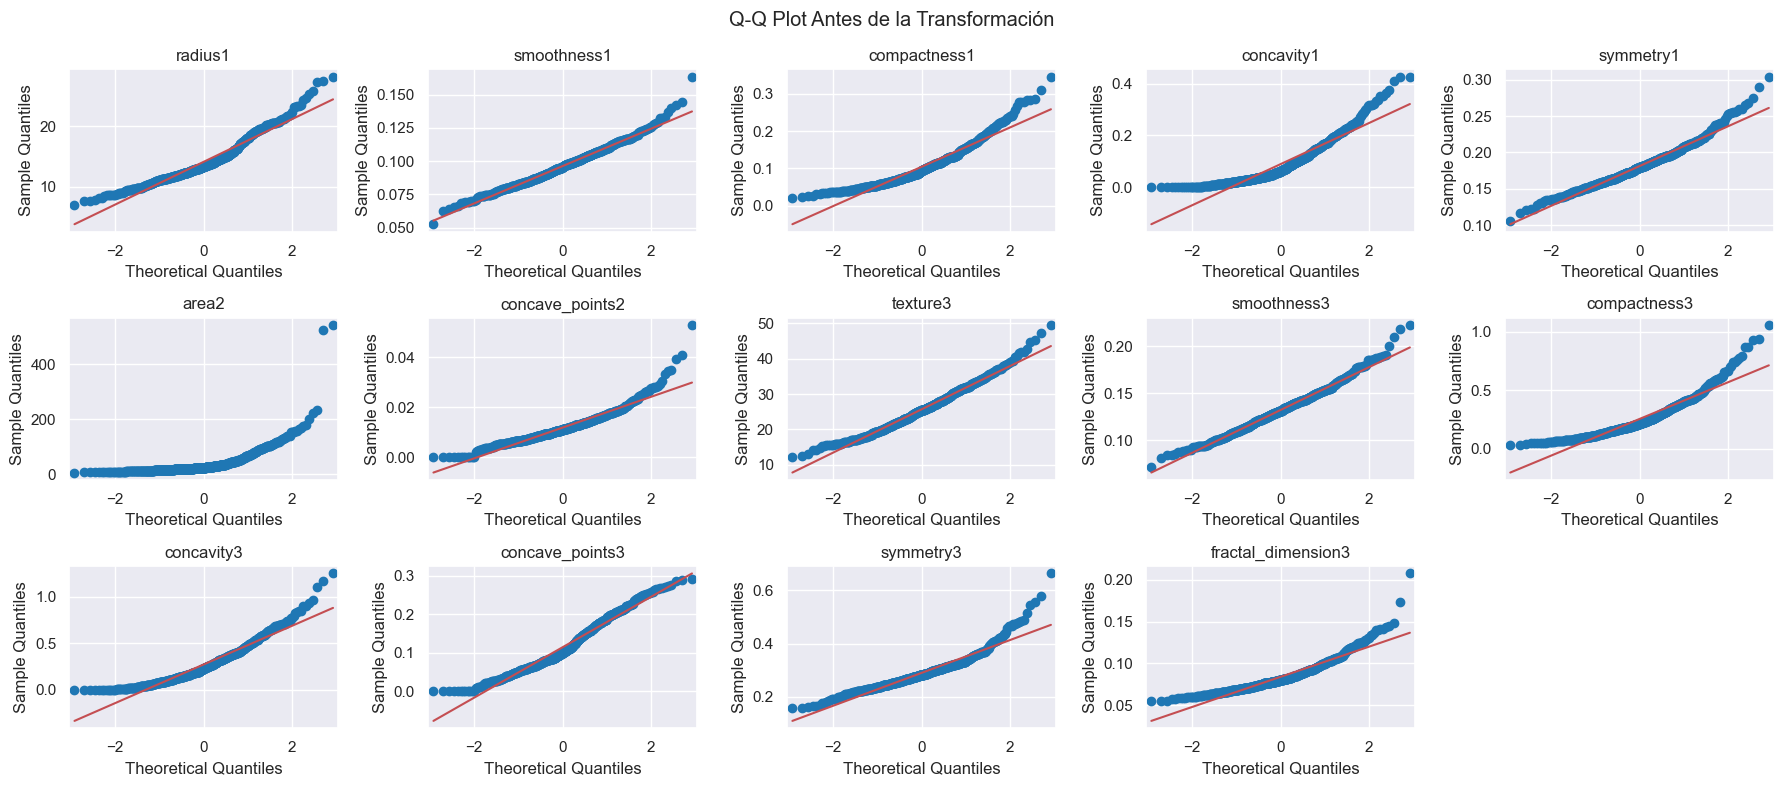

In [74]:
warnings.filterwarnings('ignore')
def qq_plots(X):
    fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(18, 8))

    # Flatten the axes array to make indexing easier
    axes = axes.flatten()

    # Generate Q-Q plots for each column
    for i, column in enumerate(X.columns):
        qqplot(X[column], line='s', ax=axes[i])
        axes[i].set_title(f'{column}')

    # Remove any empty subplots
    for j in range(i+1, len(axes)):
        fig.delaxes(axes[j])

    plt.suptitle('Q-Q Plot Antes de la Transformación')
    plt.tight_layout()
    plt.show()

qq_plots(X)

**Observaciones**  
+   La distribución de la mayoría de variables se aproximan a una normal pero se pierde en los extremos  
Requerirán un proceso de normalización para modelos a los les afecte como K-Neighbors

In [75]:
scaler = MinMaxScaler()
quantile = QuantileTransformer(output_distribution='normal', n_quantiles=100)

procesador_x = make_pipeline(scaler, quantile)

X_scaled = procesador_x.fit_transform(X)
df_X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

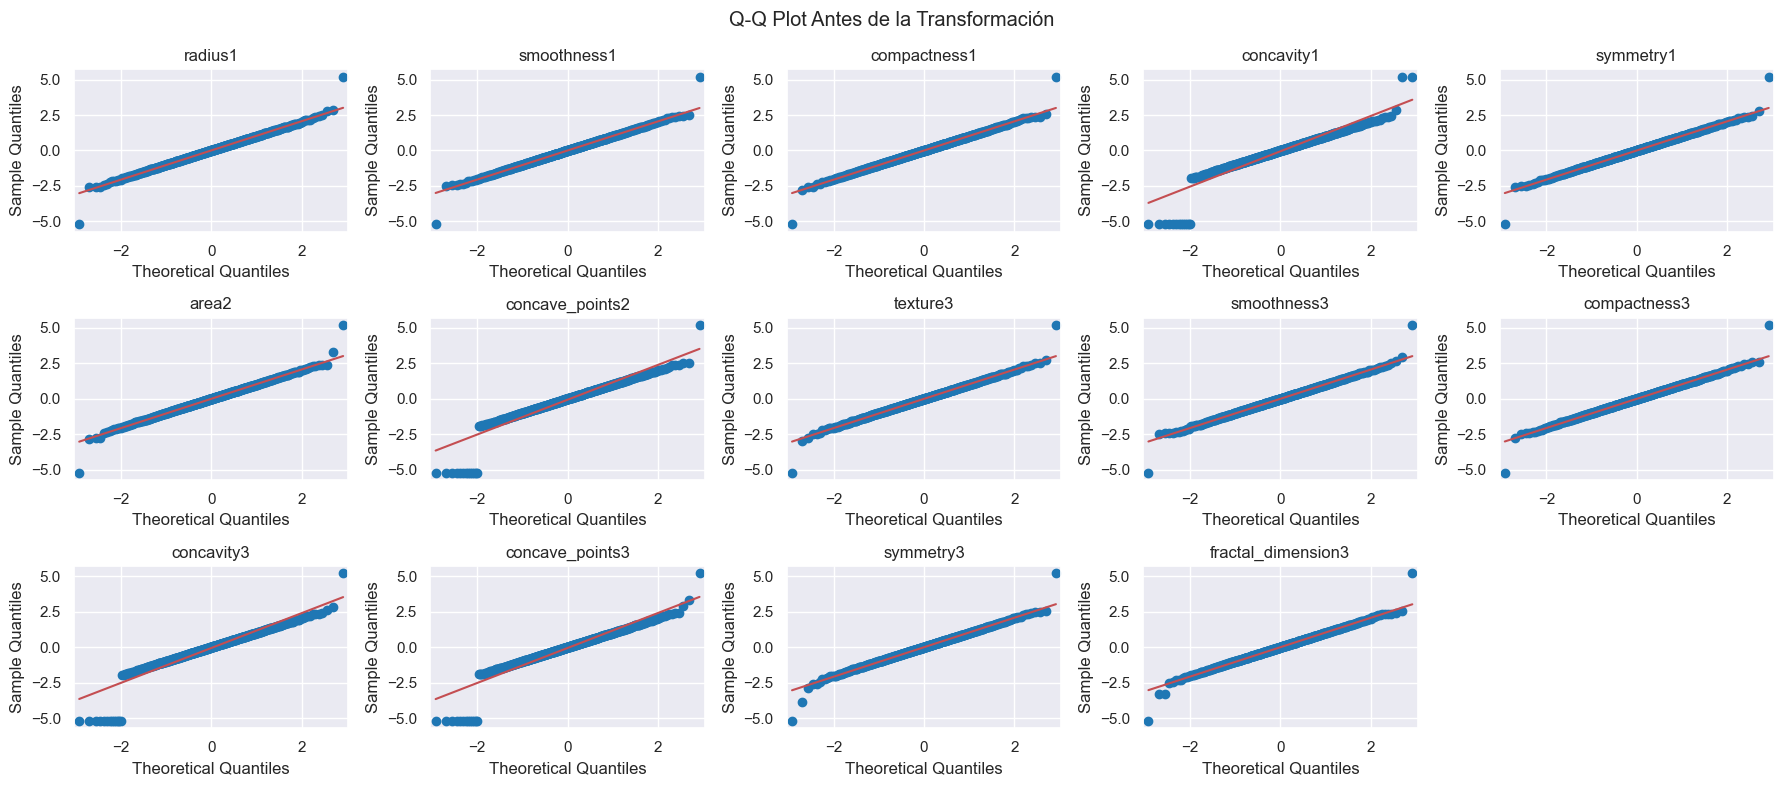

In [76]:
qq_plots(df_X_scaled)

**Observaciones**  
+   Las variables se han normalizado con exito en su mayoría, aunque todavía persisten algunas con distorsiones en los extremos

### División y balanceo de los datos

Dado que el número de tumotes benignos es muy superior que el de malignos se realizará oversampling

In [77]:
X_train_scaled, X_test_scaled, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=27)

smote = SMOTE(random_state=27)
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)

Para evitar el sobreajuste se implementará una validación cruzada estratificada

In [78]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=27)

## Entrenamiento y Evaluación de Modelos

### Funciones para la evaluación y visualización

#### Función para evaluar los modelos

Realiza 3 tareas:
1.  Imprime una tabla con metricas (f-1, recall, precision y accuracy)
2.  Visualiza una matriz de confusión (Valor real vs Predicción)
3.  Visualiza la curva AUC (Positivos Verdaderos vs Falsos)

In [79]:
def evaluar_modelo(y_test, y_pred):
    # Mostrar el reporte de clasificación
    print(classification_report(y_test, y_pred))
    
    # Generar la matriz de confusión
    cm = confusion_matrix(y_test, y_pred)

    # Visualizar la matriz de confusión
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='coolwarm', ax=ax[0])
    ax[0].set_xlabel('Predicción')
    ax[0].set_ylabel('Real')
    ax[0].set_title('Matriz de Confusión')
    
    # Visualizar la curva ROC
    roc_auc = roc_auc_score(y_test, y_pred)
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    ax[1].plot(fpr, tpr, label=f'AUC (area = {roc_auc:.2f})')
    ax[1].plot([0, 1], [0, 1], color='navy', linestyle='--')
    ax[1].set_xlabel('Tasa de Falsos Positivos')
    ax[1].set_ylabel('Tasa de Verdaderos Positivos')
    ax[1].set_title('Curva ROC')
    ax[1].legend()
    
    plt.show()
    

#### Función para visualizar la importancia de las variables

Visualiza en forma de pastel la importancia que ha tenido cada variable en el modelo 

In [80]:
variables = X.columns

def importancias(modelo):

    importancias = modelo.feature_importances_
    # Crear un DataFrame para organizar las importancias
    importancia_df = pd.DataFrame({'Variable': variables, 'Importancia': importancias})

    # Ordenar las características por importancia
    importancia_df = importancia_df.sort_values(by='Importancia', ascending=False)

    # Agrupar las importancias menores en "Otros"
    importancia_df.loc[importancia_df['Importancia'] < 0.02, 'Variable'] = 'Otros'
    importancia_df = importancia_df.groupby('Variable').sum().reset_index().sort_values(by='Importancia', ascending=False)

    # Crear el gráfico de pie
    plt.figure(figsize=(5, 5))
    plt.pie(importancia_df['Importancia'], labels=importancia_df['Variable'], autopct='%1.1f%%', startangle=0)
    plt.title('Importancia de las Características')
    plt.axis('equal')  
    plt.show()

### K Neighbors

Mejores parámetros encontrados: OrderedDict({'algorithm': 'kd_tree', 'metric': 'minkowski', 'n_neighbors': 4, 'p': 1, 'weights': 'uniform'})
              precision    recall  f1-score   support

           0       0.97      0.99      0.98        69
           1       0.98      0.96      0.97        45

    accuracy                           0.97       114
   macro avg       0.97      0.97      0.97       114
weighted avg       0.97      0.97      0.97       114



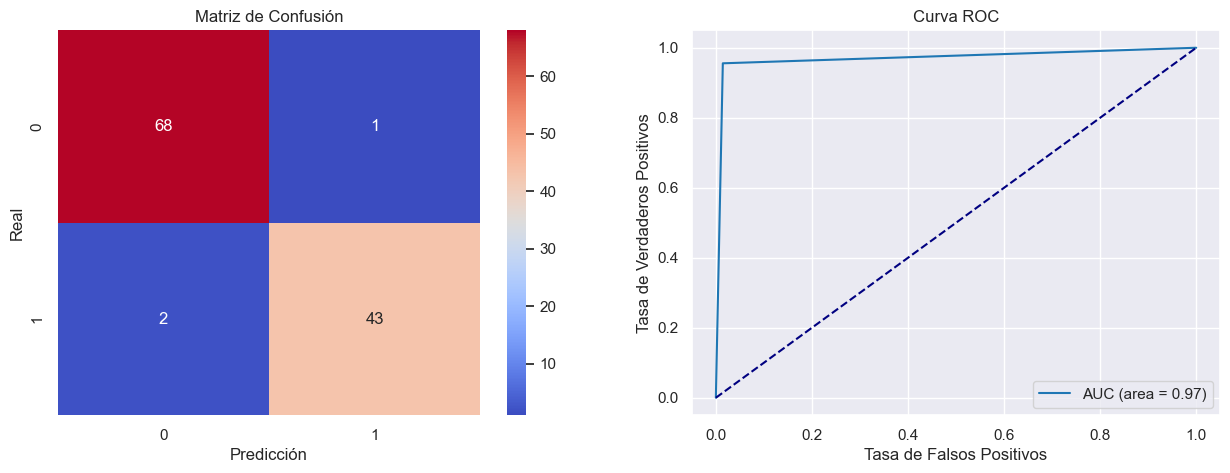

In [81]:
knn = KNeighborsClassifier()

param_space_knn = {
    'n_neighbors': Integer(1, 100),
    'weights': ['uniform', 'distance'],
    'p': Integer(1, 2),
    'metric': ['euclidean', 'manhattan', 'minkowski'],
    'algorithm': ['ball_tree', 'kd_tree', 'brute']
}

knn_opt = BayesSearchCV(
    knn,
    param_space_knn,
    n_iter=32,
    cv=skf,
    n_jobs=-1,
    random_state=27,
    scoring="accuracy"
)

knn_opt.fit(X_train_smote, y_train_smote)

print("Mejores parámetros encontrados:", knn_opt.best_params_)

knn_be = knn_opt.best_estimator_

y_pred = knn_be.predict(X_test_scaled)

evaluar_modelo(y_test, y_pred)


### Naive Bayes

              precision    recall  f1-score   support

           0       0.94      0.93      0.93        69
           1       0.89      0.91      0.90        45

    accuracy                           0.92       114
   macro avg       0.92      0.92      0.92       114
weighted avg       0.92      0.92      0.92       114



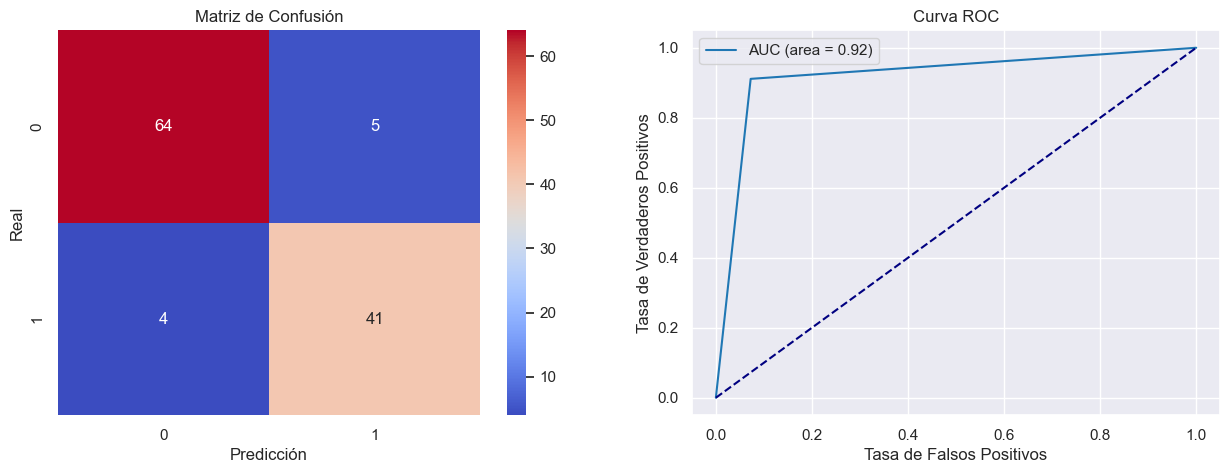

In [82]:
nb = GaussianNB()

nb.fit(X_train_scaled, y_train)

y_pred = nb.predict(X_test_scaled)

evaluar_modelo(y_test, y_pred)

### Regresión Logistica con validación cruzada

              precision    recall  f1-score   support

           0       0.96      1.00      0.98        69
           1       1.00      0.93      0.97        45

    accuracy                           0.97       114
   macro avg       0.98      0.97      0.97       114
weighted avg       0.97      0.97      0.97       114



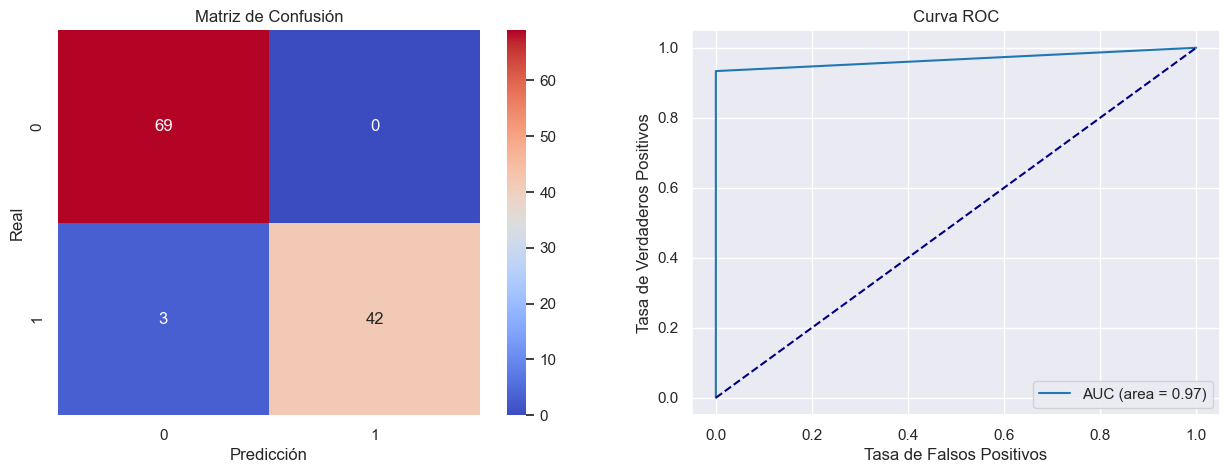

In [83]:
log_reg_cv = LogisticRegressionCV(cv=skf, max_iter=3000, random_state=27, Cs=50, solver='newton-cg', scoring = 'accuracy')

log_reg_cv.fit(X_train_smote, y_train_smote)

y_pred = log_reg_cv.predict(X_test_scaled)

evaluar_modelo(y_test, y_pred)

### Ada Boost 

Mejores parámetros encontrados: OrderedDict({'learning_rate': 1.0, 'n_estimators': 500})
              precision    recall  f1-score   support

           0       0.97      0.99      0.98        69
           1       0.98      0.96      0.97        45

    accuracy                           0.97       114
   macro avg       0.97      0.97      0.97       114
weighted avg       0.97      0.97      0.97       114



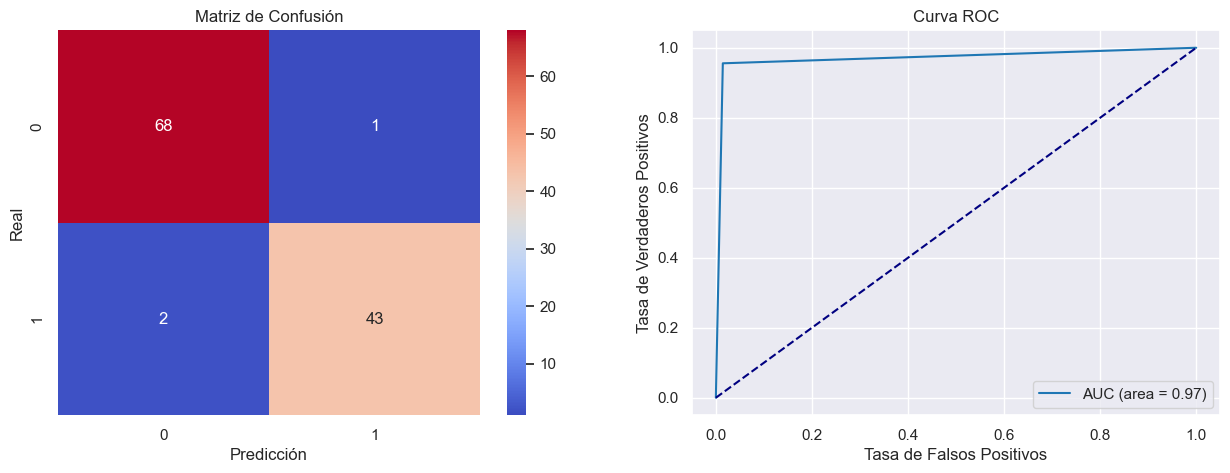

In [84]:
adaboost = AdaBoostClassifier(random_state=27, algorithm='SAMME')

param_space = {
    'n_estimators': Integer(50, 500),
    'learning_rate': Real(0.01, 1.0, prior='uniform')
}

adaboost_opt = BayesSearchCV(
    adaboost,
    param_space,
    n_iter=32,
    cv=skf,
    n_jobs=-1,
    random_state=27,
    scoring="accuracy"
)

adaboost_opt.fit(X_train_smote, y_train_smote)

print("Mejores parámetros encontrados:", adaboost_opt.best_params_)

adaboost_be = adaboost_opt.best_estimator_

y_pred = adaboost_be.predict(X_test_scaled)

evaluar_modelo(y_test, y_pred)

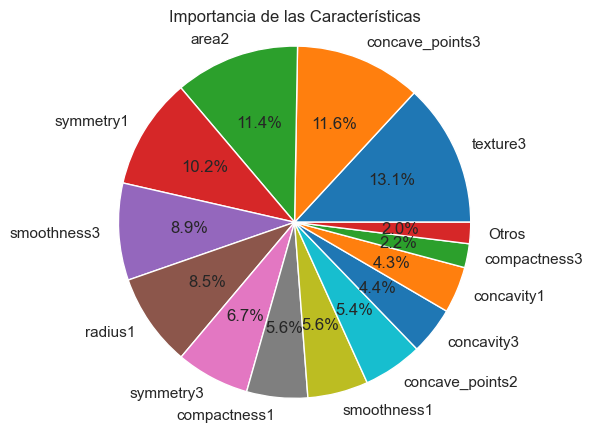

In [85]:
importancias(adaboost_be)

### Random Forest

Mejores parámetros encontrados: OrderedDict({'max_depth': 35, 'max_features': 0.2948211201587533, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 10})
              precision    recall  f1-score   support

           0       0.97      0.99      0.98        69
           1       0.98      0.96      0.97        45

    accuracy                           0.97       114
   macro avg       0.97      0.97      0.97       114
weighted avg       0.97      0.97      0.97       114



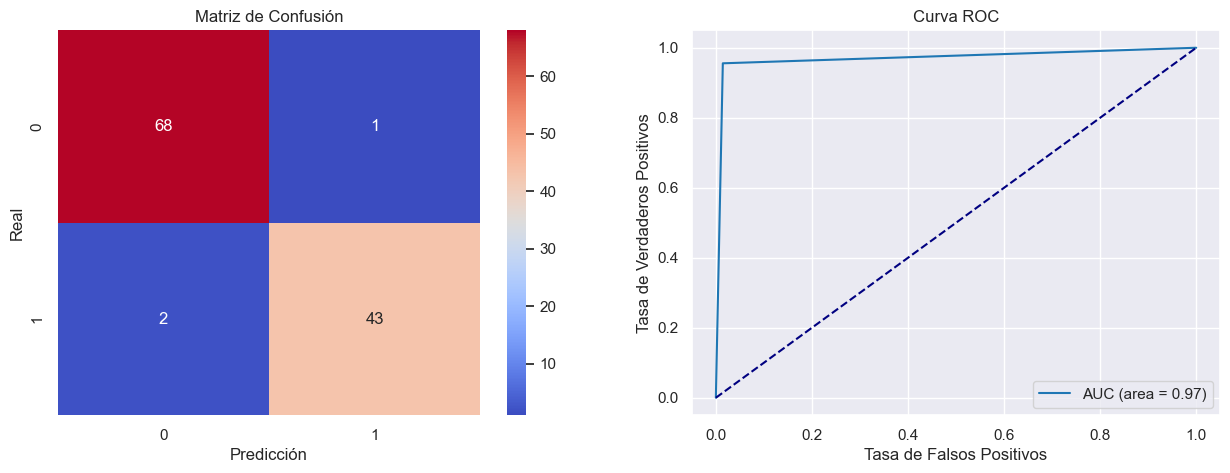

In [86]:
rf = RandomForestClassifier(random_state=27)

param_space_rf = {
    'n_estimators': Integer(10, 300),
    'max_depth': Integer(1, 50),
    'min_samples_split': Integer(2, 30),
    'min_samples_leaf': Integer(1, 30),
    'max_features': Real(0.01, 1.0, prior='uniform')
}

rf_opt = BayesSearchCV(
    rf,
    param_space_rf,
    n_iter=32,
    cv=skf,
    n_jobs=-1,
    random_state=27,
    scoring="accuracy"
)

rf_opt.fit(X_train_smote, y_train_smote)

print("Mejores parámetros encontrados:", rf_opt.best_params_)

rf_be = rf_opt.best_estimator_

y_pred = rf_be.predict(X_test_scaled)

evaluar_modelo(y_test, y_pred)


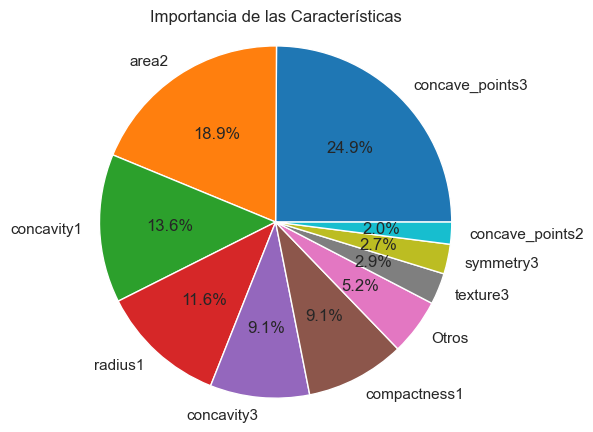

In [87]:
importancias(rf_be)

###  Gradient Boosting

Mejores parámetros encontrados: OrderedDict({'learning_rate': 0.4303358686774136, 'max_depth': 56, 'max_features': 0.2128332412213696, 'min_samples_leaf': 9, 'min_samples_split': 10, 'n_estimators': 341, 'subsample': 0.7874397467767894})
              precision    recall  f1-score   support

           0       0.96      0.99      0.97        69
           1       0.98      0.93      0.95        45

    accuracy                           0.96       114
   macro avg       0.97      0.96      0.96       114
weighted avg       0.97      0.96      0.96       114



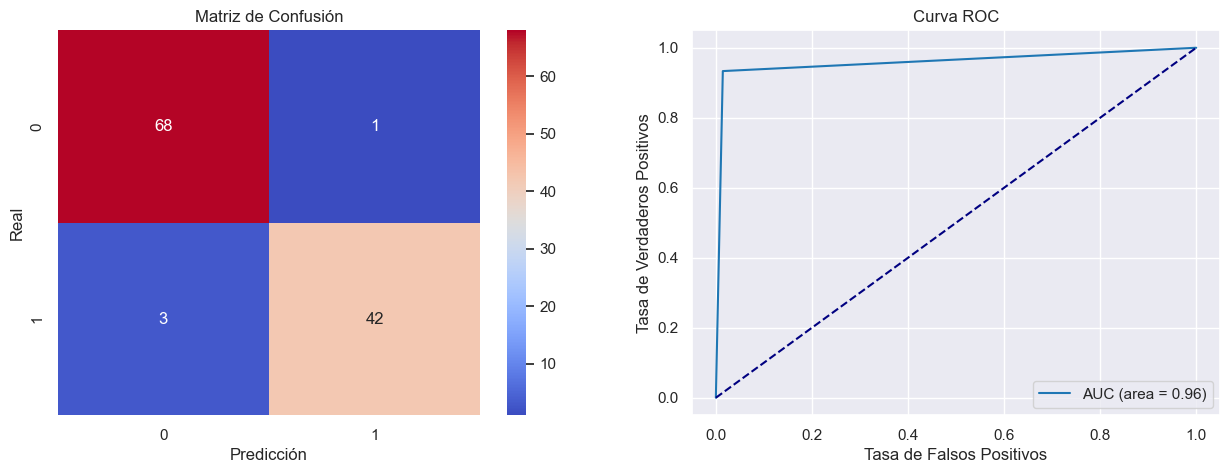

In [88]:
gbc = GradientBoostingClassifier(random_state=27)

param_space = {
    'learning_rate': Real(1e-4, 1, prior='uniform'),
    'n_estimators': Integer(10, 500),
    'max_depth': Integer(1, 100),
    'min_samples_split': Integer(2, 30),
    'min_samples_leaf': Integer(1, 30),
    'max_features': Real(0.1, 1.0, prior='uniform'),
    'subsample': Real(0.1, 1.0, prior='uniform'),
}

gbc_opt = BayesSearchCV(
    gbc,
    param_space,
    n_iter=16,
    cv=skf,
    n_jobs=-1,
    random_state=27,
    scoring="accuracy"
)

gbc_opt.fit(X_train_smote, y_train_smote)

print("Mejores parámetros encontrados:", gbc_opt.best_params_)

gbc_be = gbc_opt.best_estimator_

y_pred_gbc = gbc_be.predict(X_test_scaled)

evaluar_modelo(y_test, y_pred_gbc)


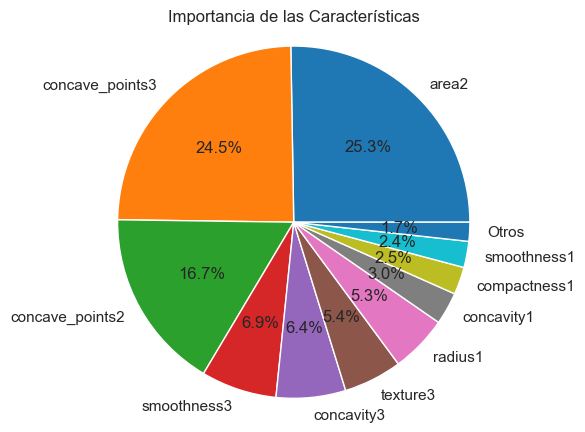

In [89]:
importancias(gbc_be)

Mejores parámetros encontrados: OrderedDict({'coef0': 7.833992452938032, 'degree': 3, 'gamma': 0.0012800934246804418, 'kernel': 'poly', 'nu': 0.21629371931415586})
              precision    recall  f1-score   support

           0       0.99      1.00      0.99        69
           1       1.00      0.98      0.99        45

    accuracy                           0.99       114
   macro avg       0.99      0.99      0.99       114
weighted avg       0.99      0.99      0.99       114



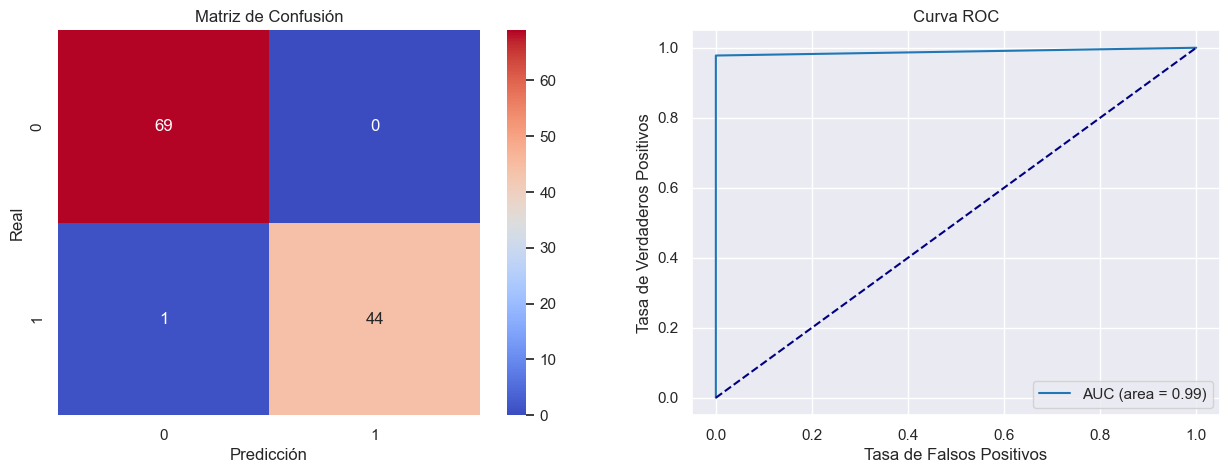

In [90]:
from sklearn.svm import NuSVC

nusvc = NuSVC(probability=True, random_state=27)

param_space_nusvc = {
    'nu': Real(0.01, 1, prior='uniform'),
    'gamma': Real(1e-6, 1e+1, prior='log-uniform'),
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'degree': Integer(1, 5),
    'coef0': Real(0, 10)
}

nusvc_opt = BayesSearchCV(
    nusvc,
    param_space_nusvc,
    n_iter=8,
    cv=skf,
    n_jobs=-1,
    random_state=27,
    scoring="accuracy"
)

nusvc_opt.fit(X_train_smote, y_train_smote)

print("Mejores parámetros encontrados:", nusvc_opt.best_params_)

nusvc_be = nusvc_opt.best_estimator_

y_pred_nusvc = nusvc_be.predict(X_test_scaled)

evaluar_modelo(y_test, y_pred_nusvc)


### Clasificación por Voto

              precision    recall  f1-score   support

           0       0.99      1.00      0.99        69
           1       1.00      0.98      0.99        45

    accuracy                           0.99       114
   macro avg       0.99      0.99      0.99       114
weighted avg       0.99      0.99      0.99       114



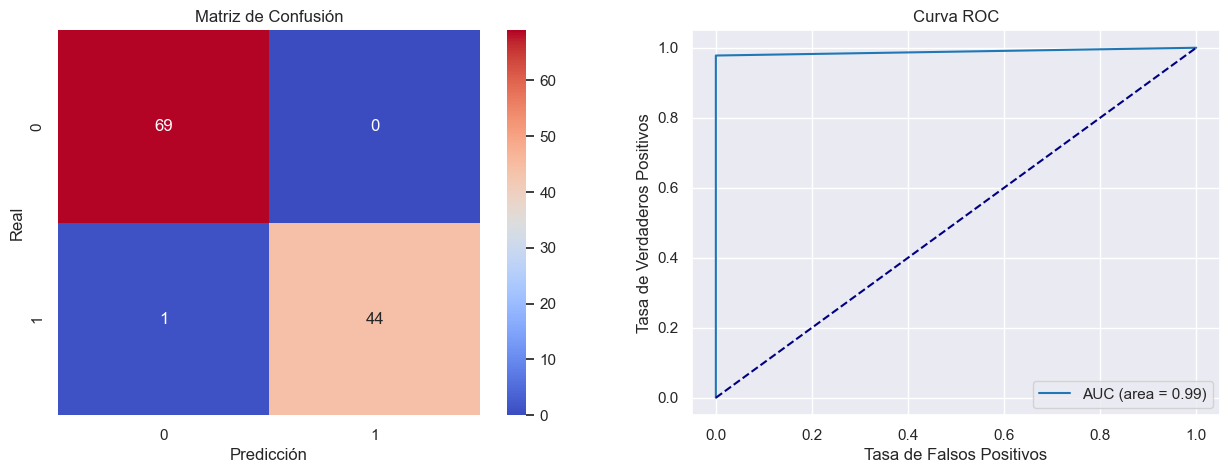

In [91]:
voting_clf = VotingClassifier(
    estimators=[
        ('adaboost', adaboost_be),
        ('rf', rf_be),
        ('gbc', gbc_be),
        ('nusvc', nusvc_be),
        ('knn', knn_be),
    ],
    voting='hard',
    n_jobs=-1
)

# Ajustar el modelo
voting_clf.fit(X_train_smote, y_train_smote)

# Realizar predicciones
y_pred_voting = voting_clf.predict(X_test_scaled)

# Evaluar el modelo
evaluar_modelo(y_test, y_pred_voting)

              precision    recall  f1-score   support

           0       0.99      1.00      0.99        69
           1       1.00      0.98      0.99        45

    accuracy                           0.99       114
   macro avg       0.99      0.99      0.99       114
weighted avg       0.99      0.99      0.99       114



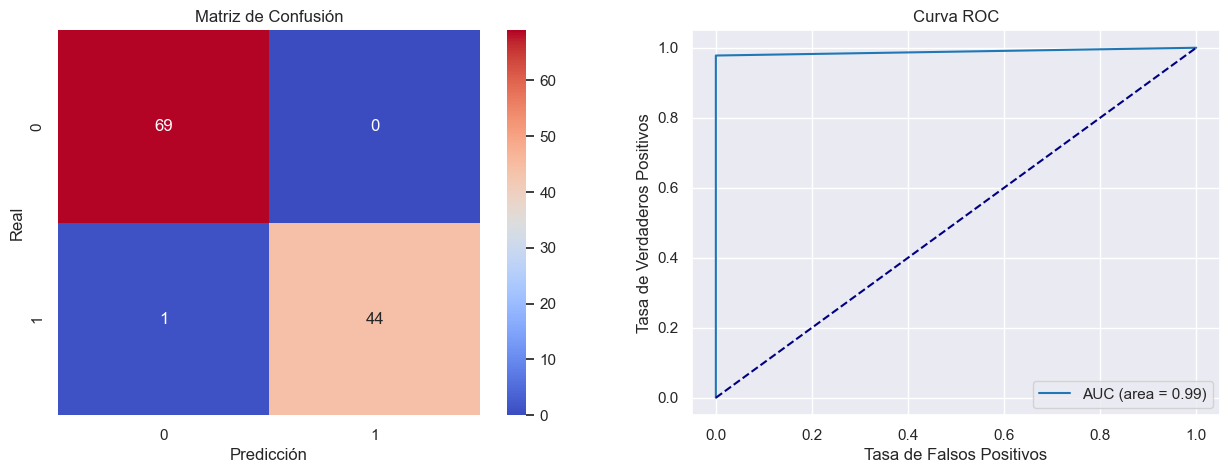

In [92]:
stacking_clf = StackingClassifier(
    estimators=[
        ('adaboost', adaboost_be),
        ('rf', rf_be),
        ('gbc', gbc_be),
        ('nusvc', nusvc_be),
        ('knn', knn_be),
    ],
    final_estimator=LogisticRegression(random_state=27, solver= 'liblinear', max_iter=5000),
    cv=skf,
    stack_method='predict',
    n_jobs=-1
)

stacking_clf.fit(X_train_smote, y_train_smote)

y_pred_stacking = stacking_clf.predict(X_test_scaled)

evaluar_modelo(y_test, y_pred_stacking)

## Evaluación Final de los Modelos

In [93]:
resumen = pd.DataFrame()

resumen['Modelos'] = ['LogisticRegressionCV', 'KNN Classification', 'Naive Bayes', 'AdaBoost Classifier', 'Random Forest', 'Gradient Boosting', 'NuSVC', 'Voting Classifier', 'Stacking Classifier']

resumen['Precisión con los datos de entrenamiento'] =  [log_reg_cv.score(X_train_smote, y_train_smote) * 100,
                                                        knn_be.score(X_train_smote, y_train_smote) * 100,
                                                        nb.score(X_train_smote, y_train_smote) * 100,
                                                        adaboost_be.score(X_train_smote, y_train_smote) * 100,
                                                        rf_be.score(X_train_smote, y_train_smote) * 100,
                                                        gbc_be.score(X_train_smote, y_train_smote) * 100,
                                                        nusvc_be.score(X_train_smote, y_train_smote) * 100,
                                                        voting_clf.score(X_train_smote, y_train_smote) * 100,
                                                        stacking_clf.score(X_train_smote, y_train_smote) * 100]

resumen['Precisión con los datos de prueba'] =         [log_reg_cv.score(X_test_scaled, y_test) * 100,
                                                        knn_be.score(X_test_scaled, y_test) * 100,
                                                        nb.score(X_test_scaled, y_test) * 100,
                                                        adaboost_be.score(X_test_scaled, y_test) * 100,
                                                        rf_be.score(X_test_scaled, y_test) * 100,
                                                        gbc_be.score(X_test_scaled, y_test) * 100,
                                                        nusvc_be.score(X_test_scaled, y_test) * 100,
                                                        voting_clf.score(X_test_scaled, y_test) * 100,
                                                        stacking_clf.score(X_test_scaled, y_test) * 100]  

resumen['Precisión con todos los datos'] =             [log_reg_cv.score(X_scaled, y) * 100,
                                                        knn_be.score(X_scaled, y) * 100,
                                                        nb.score(X_scaled, y) * 100,
                                                        adaboost_be.score(X_scaled, y) * 100,
                                                        rf_be.score(X_scaled, y) * 100,
                                                        gbc_be.score(X_scaled, y) * 100,
                                                        nusvc_be.score(X_scaled, y) * 100,
                                                        voting_clf.score(X_scaled, y) * 100,
                                                        stacking_clf.score(X_scaled, y) * 100]

resumen.sort_values(by=['Precisión con todos los datos','Precisión con los datos de prueba','Precisión con los datos de entrenamiento'] , ascending=False).reset_index(drop=True)

,Modelos,Precisión con los datos de entrenamiento,Precisión con los datos de prueba,Precisión con todos los datos
0,Voting Classifier,100.000000,99.122807,99.824253
1,Stacking Classifier,100.000000,99.122807,99.824253
2,AdaBoost Classifier,100.000000,97.368421,99.472759
3,Random Forest,100.000000,97.368421,99.472759
4,Gradient Boosting,100.000000,96.491228,99.297012
5,NuSVC,98.090278,99.122807,98.242531
6,LogisticRegressionCV,98.090278,97.368421,97.891037
7,KNN Classification,97.569444,97.368421,97.363796
8,Naive Bayes,90.625000,92.105263,91.739895


### Conclusión

He dividido los modelos en 4 grupos en base a sus resultados en cada sección de la tabla anterior.

##### Grupo 1: Alto Rendimiento y Máxima Precisión

**Modelos:** Voting Classifier y Stacking Classifier

- **Interpretación:**
  - Estos modelos muestran el mejor desempeño general, lo que sugiere una excelente capacidad para generalizar sin perder rendimiento en los datos no vistos.

##### Grupo 2: Rendimiento Elevado con Posible Sobreajuste

**Modelos:** AdaBoost Classifier, Random Forest y Gradient Boosting

- **Interpretación:**
  - La perfecta precisión en entrenamiento contrasta con una ligera disminución en la prueba, lo que puede indicar un grado de sobreajuste. Aún así, mantienen un rendimiento muy alto.

##### Grupo 3: Consistencia y Equilibrio entre Entrenamiento y Prueba

**Modelos:** NuSVC, LogisticRegressionCV y KNN Classification

- **Interpretación:**
  - Estos modelos presentan diferencias mínimas entre los datos de entrenamiento y prueba, lo que indica estabilidad y menor riesgo de sobreajuste, a pesar de que sus valores globales son ligeramente inferiores a los del Grupo 1, sin embargo por la naturaleza de los datos ese 2% de diferencia podría suponer más de un cancer mal diagnosticado.

##### Grupo 4: Rendimiento Inferior

**Modelo:** Naive Bayes

- **Interpretación:**
  - Con resultados notablemente inferiores en comparación con los otros modelos, Naive Bayes parece ser menos adecuado para este conjunto de datos, a su favor he de decir que no requiere de optimización de hiperparámetros y no tiene a penas coste computacional.

### Conclusión

- *Voting* y *Stacking Classifier* se destacan por alcanzar la mayor precisión, mostrando un rendimiento sobresaliente en todos los conjuntos de datos.
- Los modelos basados en técnicas de ensamble (*AdaBoost*, *Random Forest* y *Gradient Boosting*) muestran un rendimiento muy alto en entrenamiento, pero la pequeña brecha con la precisión de prueba sugiere la necesidad de revisar posibles signos de sobreajuste.
- *NuSVC*, *LogisticRegressionCV* y *KNN Classification* presentan un rendimiento consistente y equilibrado, lo que los hace modelos estables para la tarea.
- *Naive Bayes* tiene bajo rendimiento pero tambien un bajo coste computacional.